In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import emcee
import corner
from multiprocess import Pool
from numba import njit, vectorize
# from numba_stats import norm
import math
from iminuit import cost, Minuit 
from numba_stats import norm
from tqdm import tqdm

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = 661.657
Emin = 658.
Emax = 665.

path = '/Users/sean/COSI/calibration_data/2016/Cs137/'
plot_dir = '/Users/sean/COSI/ChargeTrapping/figures/'
dat_all = 'COSI_GCU-040516_091215-204526_Cs137_allmodules.alldata-003.dat'

# Use Cs-137 data from 2016 calibrations (Run 90)


## Read in the dat file

In [2]:
df_dat = make_df_from_dat(path+dat_all)

In [3]:
# This is the pixel code alex used in depth calibration
df_dat["pixel_code"] = 10000*df_dat["det"]+100*df_dat["strip_n"]+df_dat["strip_p"]

## Choose a detector and plot the counts as a function of depth

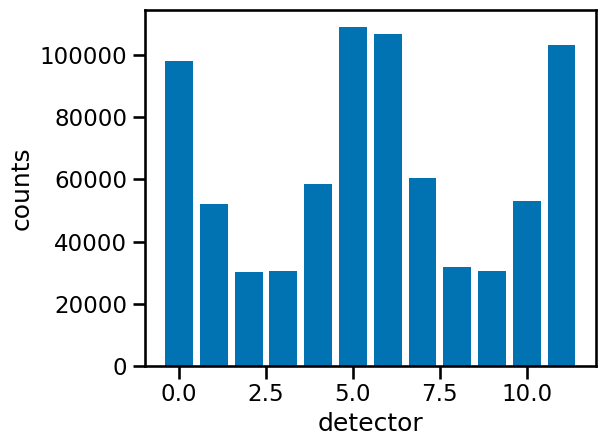

In [4]:
det_counts = [len(df_dat.loc[(df_dat["det"]==i)]) for i in range(12)]
plt.figure()
plt.bar(range(12), det_counts);
# plt.yscale('log')
plt.xlabel("detector")
plt.ylabel("counts")
plt.tight_layout()
# plt.savefig(plot_dir + 'counts_per_det.pdf')

[-5.321   -3.83392 -2.7877  -1.29404 -0.24782 -0.22808  1.259  ]
0.18588499999999997
0.1867075
0.185885


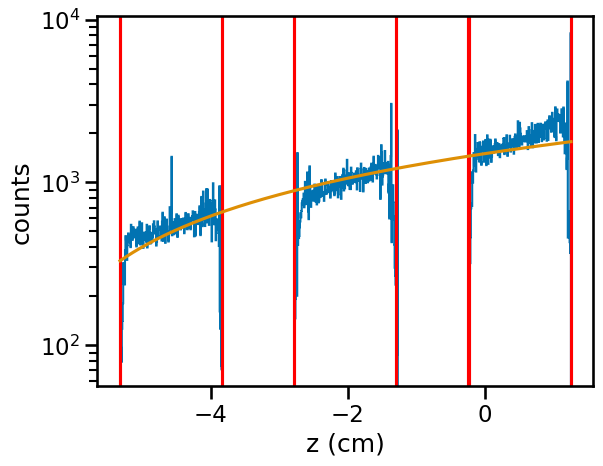

In [5]:
plt.figure()
hist, bins, _ = plt.hist(df_dat["z"], bins=1000, histtype = "step");
plt.yscale('log')
plt.xlabel("z (cm)")
plt.ylabel("counts");

det_edges = np.sort(np.concatenate([[bins[0]], bins[np.argsort((hist[:-1]-hist[1:])/(220*bins[:-2] + 1500))][1:6], [bins[-1]]]))
print(det_edges)
for e in det_edges:
    plt.axvline(e, color='red')
    
plt.plot(bins, 220*bins + 1500)

# plt.figure()
# plt.plot(bins[:-1], hist.astype(bool))

det_edges = [[-5.321, -3.83392], [-2.7877, -1.29404], [-0.22808, 1.259]]
for e in det_edges:
    print((e[1]-e[0])/8)

In [6]:
z_min = det_edges[0][0]       # cm
z_max = det_edges[-1][-1]
temp_list = []
num_z=15
for e in det_edges:
    temp_list.append(np.linspace(e[0],e[1], num_z+1))

z_bins = np.concatenate(temp_list)
z_bins_labels = np.arange(0,len(z_bins)-1)
print(z_bins)
df_dat["z_binned"] = pd.cut(df_dat["z"],bins=z_bins,labels=z_bins_labels)


[-5.321      -5.22186133 -5.12272267 -5.023584   -4.92444533 -4.82530667
 -4.726168   -4.62702933 -4.52789067 -4.428752   -4.32961333 -4.23047467
 -4.131336   -4.03219733 -3.93305867 -3.83392    -2.7877     -2.68812267
 -2.58854533 -2.488968   -2.38939067 -2.28981333 -2.190236   -2.09065867
 -1.99108133 -1.891504   -1.79192667 -1.69234933 -1.592772   -1.49319467
 -1.39361733 -1.29404    -0.22808    -0.12894133 -0.02980267  0.069336
  0.16847467  0.26761333  0.366752    0.46589067  0.56502933  0.664168
  0.76330667  0.86244533  0.961584    1.06072267  1.15986133  1.259     ]


# Perform correction depth bin by depth bin

In [20]:
pnflipped = [True, True, True, False, False, False, True, True, True, False, False, False]
det_layers = [2,1,0,0,1,2,2,1,0,0,1,2]
# dets = [0,1,2,3,4,5,6,7,8,9,10,11]
dets = [2,4,8]
# 11 has high-E excess, messing up fits. 5,6, 10 have low-E bump. 0 and 1 have wiggles near the peak.
# 9 is really broad on the hole signal
# Best-looking fits: 2, 4, 8

for j, side in enumerate(['p', 'n']):
    if side=='p':
        carrier='electron'
    else:
        carrier='hole'

    # color = 'C' + str(j)
    
    for det in dets:

        print('Det ', det)

        df_dat_det = df_dat[df_dat["det"]==det]
        z_binned_freq_values = df_dat_det["z_binned"].value_counts().index.to_list()

        z_list = []
        z_freq_depthsort = np.sort(z_binned_freq_values[:num_z])

        if pnflipped[det]:
            top = det_edges[det_layers[det]][0]
        else:
            top = det_edges[det_layers[det]][1]
            
        energies = []
        depths = []
        for i in range(num_z):

            z = z_freq_depthsort[i]
            z_list.append(z)
            
            energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values)

            if pnflipped[det]:
                depths.append(df_dat_det[df_dat_det["z_binned"]==z]["z"].values-top)
            else:
                depths.append(top-df_dat_det[df_dat_det["z_binned"]==z]["z"].values)
        
        energies = np.concatenate(energies)
        depths = np.concatenate(depths)
        energy_mask = (energies > Emin) * (energies < Emax)
        energies = energies[energy_mask]
        depths = depths[energy_mask]
        xy = np.vstack([energies, depths])
        rho = stats.gaussian_kde(xy)(xy)
        plt.scatter(energies, depths, c=rho, s=0.05)
        plt.axvline(Cs_line, color='red', lw=0.8)
        # plt.ylim(0.0,1.5)
        plt.ylabel('Depth (cm)')
        plt.xlabel('Energy (keV)')
        plt.tight_layout()
        plt.savefig(plot_dir + 'unbinned_energy_depth_det' + str(det) + '_' + str(side) + '.pdf')
        plt.close()

Det  2
Det  4
Det  8
Det  2
Det  4
Det  8
